# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

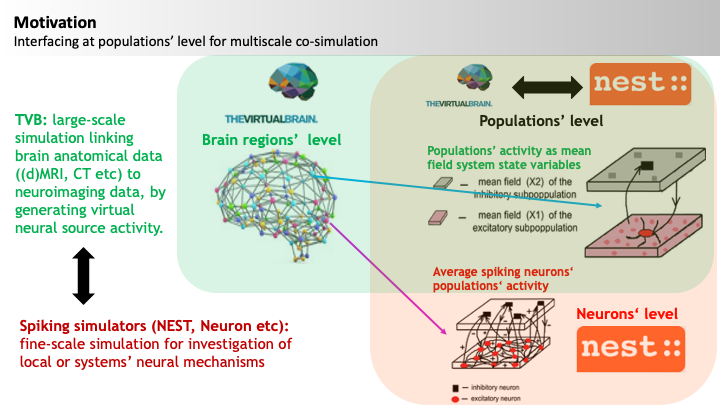

In [1]:
from IPython.core.display import Image, display
display(Image(filename='pics/ConceptGraph1.png',  width=1000, unconfined=False))

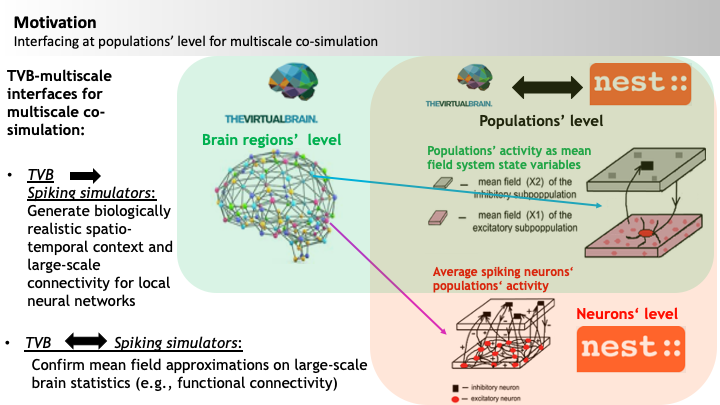

In [2]:
display(Image(filename='pics/ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB - NEST co-simulation 

## Wilson - Cowan TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

Population activity dynamics (1 excitatory and 1 inhibitory population):

 $\dot{E}_k = \dfrac{1}{\tau_e} (-E_k  + (k_e - r_e E_k) \mathcal{S}_e (\alpha_e \left( c_{ee} E_k - c_{ei} I_k  + P_k - \theta_e + \mathbf{\Gamma}(E_k, E_j, u_{kj}) + W_{\zeta}\cdot E_j + W_{\zeta}\cdot I_j\right) )) $
 
$
            \dot{I}_k = \dfrac{1}{\tau_i} (-I_k  + (k_i - r_i I_k) \mathcal{S}_i (\alpha_i \left( c_{ie} E_k - c_{ee} I_k  + Q_k - \theta_i + \mathbf{\Gamma}(E_k, E_j, u_{kj}) + W_{\zeta}\cdot E_j + W_{\zeta}\cdot I_j\right) ))$


## Spiking network model in NEST

using "iaf_cond_alpha" spiking neuronal model.

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ w_{TVB->NEST} * E(t) $, 

Inhomogeneous spike generator NEST devices are used as TVB "proxy" nodes and generate independent Poisson-random spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $

Alternatively, the spike trains are generated outside NEST using the Elephant software and inserted to NEST via spike generator devices.



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides

$ {E_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in E_n}}{N_E * dt} $ 

$ {I_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in I_n}}{N_I * dt} $

in  spikes/sec.

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


## Simulator loop

### Simulating several (i.e., minimally 2) NEST time steps for every 1 TVB time step for stable integration

### Synchronizaion every minimum delay time between the two simulators.

# WORKFLOW:

In [3]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

# ----------- Simulation options ----------------
SIM_MODE = "tvb-nest"  # "tvb-nest"  for multiscale cosimulation, "tvb" ("nest") for only TVB (NEST) simulation, respectively
NEST_MODEL_BUILDERS = None #  , "opinionated", "nonopinionated", None

# For a minimal example, select:
n_regions = 4 # total TVB brain regions
nest_nodes_inds = np.array([0, 1])  # the brain region nodes to place spiking networks from [0, n_regions-1] interval
n_neurons = 10 # number of neurons per spiking population
# -----------------------------------------------

work_path = os.getcwd()
outputs_path = os.path.join(work_path, "outputs/WilsonCowanMin")
if NEST_MODEL_BUILDERS is None:
    outputs_path += "NoNestBuilders"
elif NEST_MODEL_BUILDERS == "opinionated":
    outputs_path += "OpinionBuilders"
elif NEST_MODEL_BUILDERS == "nonopinionated":
    outputs_path += "NonOpinionBuilders"
    
if SIM_MODE.lower() == "nest":
    outputs_path += "NESTonly"
elif SIM_MODE.lower() == "tvb":
    outputs_path += "TVBonly"
    
config = Config(output_base=outputs_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2022-01-20 15:46:09,764 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-01-20 15:46:09,764 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-01-20 15:46:09,771 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-01-20 15:46:09,771 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-01-20 15:46:09,775 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-01-20 15:46:09,775 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-01-20 15:46:09,780 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-01-20 15:46:09,780 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-01-20 15:46:09,784 - INFO - tvb_multiscale.tv

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

{'integrator.dt': 0.1, 'connectivity.number_of_regions': 4, 'connectivity.region_labels': array(['bankssts_L', 'bankssts_R', 'caudalanteriorcingulate_L',
       'caudalanteriorcingulate_R'], dtype='<U128'), 'connectivity.weights': array([[0.        , 0.00718249, 0.08288281, 0.75569778],
       [0.00517479, 0.        , 0.60361627, 0.        ],
       [0.04956912, 0.2400011 , 0.        , 0.        ],
       [1.04311216, 0.        , 0.        , 0.        ]]), 'connectivity.delays': array([[ 0.        , 39.98974333, 34.00171   , 25.066129  ],
       [39.98974333,  0.        , 14.00699533,  0.        ],
       [34.00171   , 14.00699533,  0.        ,  0.        ],
       [25.066129  ,  0.        ,  0.        ,  0.        ]]), 'model': 'WilsonCowan', 'model.nvar': 2, 'model.nintvar': 2, 'model.state_variables': ['E', 'I'], 'model.cvar': array([0], dtype=int32), 'monitor.period': 0.1, 'synchronization_time': 0.0, 'synchronization_n_step': 0.0, 'integrator.noise.nsig': array([[[0.001]],

      

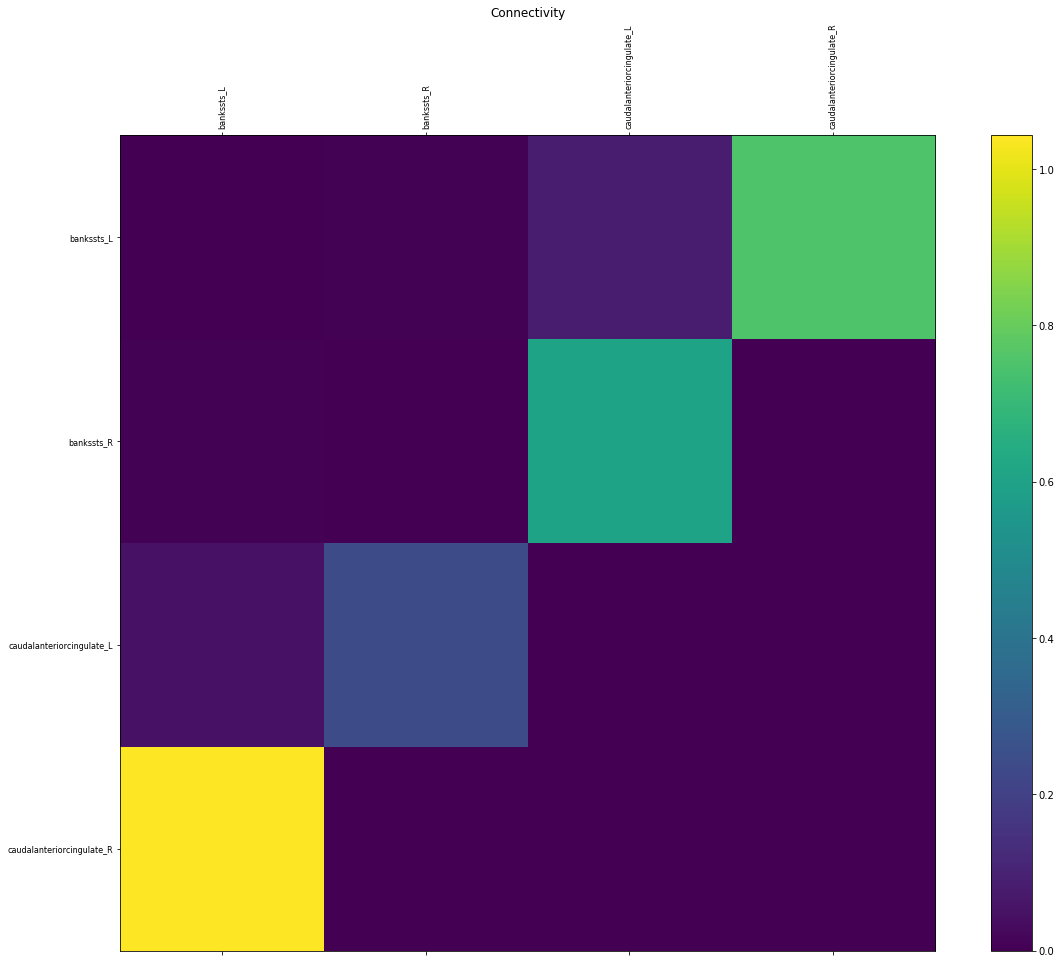

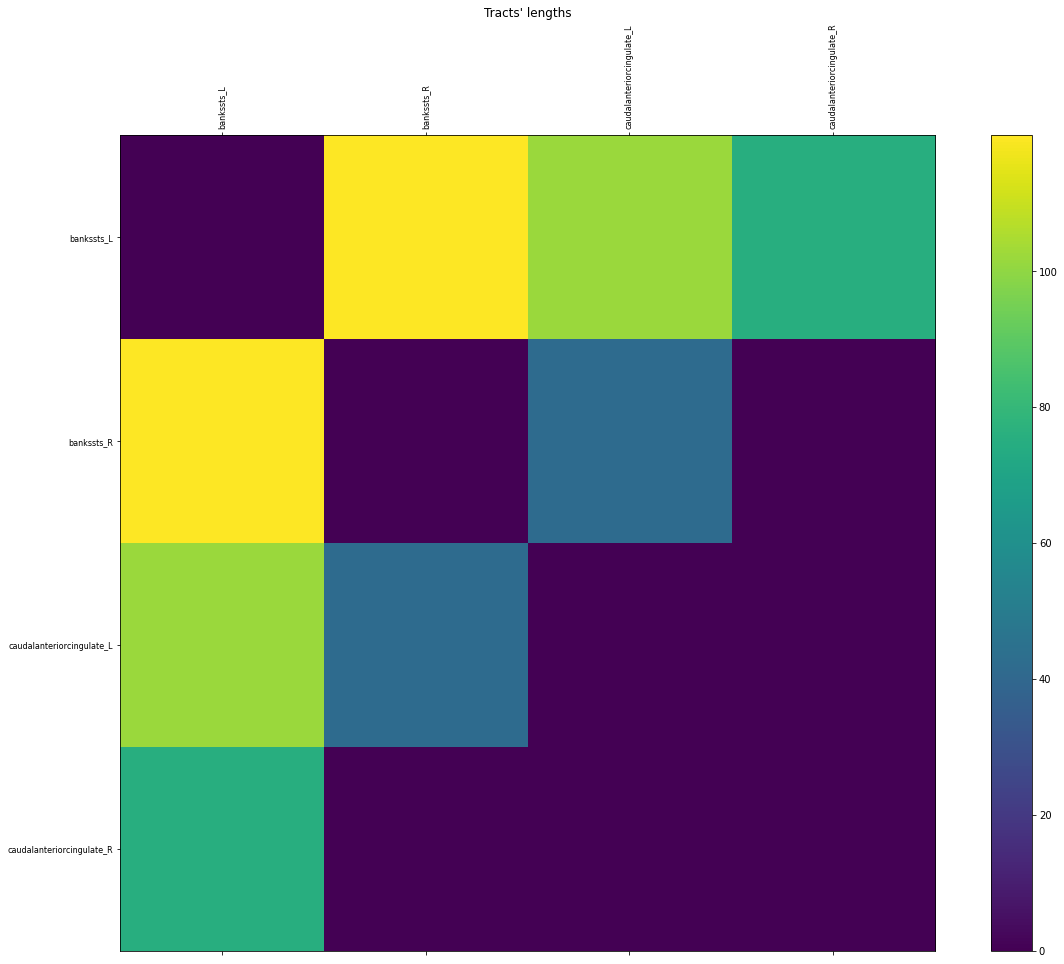

In [4]:
# This would run on TVB only before creating any multiscale cosimulation interface connections.

from tvb_multiscale.core.tvb.cosimulator.models.wilson_cowan_constraint import WilsonCowan


# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
# -----------------------------------Wilson Cowan oscillatory regime--------------------------------
model_params = {
        "r_e": np.array([0.0]),
        "r_i": np.array([0.0]),
        "k_e": np.array([1.0]),
        "k_i": np.array([1.0]),
        "tau_e": np.array([10.0]),
        "tau_i": np.array([10.0]),
        "c_ee": np.array([10.0]),
        "c_ei": np.array([6.0]),
        "c_ie": np.array([10.0]),
        "c_ii": np.array([1.0]),
        "alpha_e": np.array([1.2]),
        "alpha_i": np.array([2.0]),
        "a_e": np.array([1.0]),
        "a_i": np.array([1.0]),
        "b_e": np.array([0.0]),
        "b_i": np.array([0.0]),
        "c_e": np.array([1.0]),
        "c_i": np.array([1.0]),
        "theta_e": np.array([2.0]),
        "theta_i": np.array([3.5]),
        "P": np.array([0.5]),
        "Q": np.array([0.0])
    }


# -----------------------------------Build cosimunlator manually--------------------------------
from tvb_multiscale.core.tvb.cosimulator.cosimulator_serial import CoSimulatorSerial
from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG

simulator = CoSimulatorSerial()

simulator.model = WilsonCowan(**model_params)

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([config.DEFAULT_NSIG, config.DEFAULT_NSIG]) # 0.001


# Load connectivity
# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)


# -------------- Pick a minimal brain of only the first n_regions regions: ----------------
n_regions = 4
connectivity.number_of_regions = n_regions
connectivity.region_labels = connectivity.region_labels[:n_regions]
connectivity.centres = connectivity.centres[:n_regions]
connectivity.areas = connectivity.areas[:n_regions]
connectivity.orientations = connectivity.orientations[:n_regions]
connectivity.hemispheres = connectivity.hemispheres[:n_regions]
connectivity.cortical = connectivity.cortical[:n_regions]
connectivity.weights = connectivity.weights[:n_regions][:, :n_regions]
connectivity.tract_lengths = connectivity.tract_lengths[:n_regions][:, :n_regions]
# Remove diagonal self-connections:
np.fill_diagonal(connectivity.weights, 0.0)
# -----------------------------------------------------------------------------------------


# Normalize connectivity weights
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
# connectivity.weights[connectivity.weights > 1.0] = 1.0

# connectivity.tract_lengths = np.maximum(connectivity.speed * simulator.integrator.dt, 
#                                         connectivity.tract_lengths)

connectivity.configure()

simulator.connectivity = connectivity

simulator.initial_conditions = np.zeros((1, 2, connectivity.number_of_regions, 1))

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.configure()


# # -----------------------------------Or use the CoSimulator builder--------------------------------
# from tvb_multiscale.core.tvb.cosimulator.cosimulator_builder import CoSimulatorSerialBuilder

# simulator_builder = CoSimulatorSerialBuilder()
# simulator_builder.config = config
# simulator_builder.model = WilsonCowan()
# simulator_builder.model_params = model_params
# simulator_builder.initial_conditions = np.zeros((1, 1, 1, 1))

# simulator_builder.configure()

# simulator = simulator_builder.build()


# Plot TVB connectome:
plotter.plot_tvb_connectivity(simulator.connectivity);


# Serializing TVB cosimulator is necessary for parallel cosimulation:
from tvb_multiscale.core.tvb.cosimulator.cosimulator_serialization import serialize_tvb_cosimulator, dump_serial_tvb_cosimulator
sim_serial_filepath = os.path.join(config.out.FOLDER_RES, "tvb_serial_cosimulator.pkl")
sim_serial = serialize_tvb_cosimulator(simulator)
print(sim_serial)

# Dumping the serialized TVB cosimulator to a file will be necessary for parallel cosimulation.
dump_serial_tvb_cosimulator(sim_serial, sim_serial_filepath)


## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [5]:
# This would run on NEST only before creating any multiscale cosimulation interface connections.
# Here it is assumed that the TVB simulator is already created and we can get some of its attributes, 
# either by directly accessing it, or via serialization.


nest = None
nest_network = None
    
if "nest" in SIM_MODE.lower():
    
    # Build a NEST network model with the corresponding builder
    from tvb_multiscale.tvb_nest.nest_models.builders.nest_factory import load_nest, configure_nest_kernel

    from tvb_multiscale.core.tvb.cosimulator.cosimulator_serialization import load_serial_tvb_cosimulator
    sim_serial = load_serial_tvb_cosimulator(sim_serial_filepath)

    # Load NEST and use defaults to configure its kernel:
    nest = configure_nest_kernel(load_nest(config=config), config)

    # Local (i.e. within brain region) neuronal populations' connections' rescaling
    # to account for the reduction (increase) to the number of neurons,
    # with respect to the originally set 100 neurons per population.
    w_n_neurons_factor = 100.0 / n_neurons

    if NEST_MODEL_BUILDERS:

        if NEST_MODEL_BUILDERS == "opinionated":

            # ------------------- Instantiating an opinionated nest network builder for this model, ------------------- 
            # using all default parameters for this example

            from tvb_multiscale.tvb_nest.nest_models.models.wilson_cowan import WilsonCowanBuilder

            nest_model_builder = WilsonCowanBuilder(sim_serial,  # simulator, 
                                                    spiking_nodes_inds=nest_nodes_inds, nest_instance=nest, config=config)

            # ... or modifying some of the builder's attributes:
            nest_model_builder.w_ee = w_n_neurons_factor * sim_serial['model.c_ee'][0]  # simulator.model.c_ie[0]
            nest_model_builder.w_ei = w_n_neurons_factor * sim_serial['model.c_ei'][0]  # simulator.model.c_ie[0]
            nest_model_builder.w_ie = -w_n_neurons_factor * sim_serial['model.c_ie'][0] # simulator.model.c_ie[0]
            nest_model_builder.w_ii = -w_n_neurons_factor * sim_serial['model.c_ii'][0] # simulator.model.c_ii[0]
            nest_model_builder.output_devices_record_to = "memory"  # "ascii"
            nest_model_builder.populations_order = n_neurons
            nest_model_builder.tvb_to_spiking_dt_ratio = 2 # 2 NEST integration steps for 1 TVB integration step
            nest_model_builder.monitor_period = 1.0

        else:

            # ------ Alternatively, instantiating a non-opinionated nest network builder for this model, ----------------- 
            # ... and setting desired network description:

            from tvb_multiscale.tvb_nest.nest_models.builders.base import NESTNetworkBuilder

            nest_model_builder = NESTNetworkBuilder(sim_serial, # simulator, 
                                                    spiking_nodes_inds=nest_nodes_inds, nest_instance=nest, config=config)
            nest_model_builder.output_devices_record_to = "memory"  # "ascii"
            nest_model_builder.populations_order = n_neurons
            nest_model_builder.tvb_to_spiking_dt_ratio = 2 # 2 NEST integration steps for 1 TVB integration step
            nest_model_builder.monitor_period = 1.0

            # Set populations:
            nest_model_builder.populations = []
            for pop in ["E", "I"]:
                nest_model_builder.populations.append(
                    {"label": pop, 
                     "model": config.DEFAULT_SPIKING_MODEL,  # "iaf_cond_alpha" by default
                     # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                     "params": {},   # parameters for NEST neuronal model
                     "scale": 1.0,   # nest_model_builder.multiply populations_order for the exact populations' size
                     # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                     "nodes": None}) # None means "all" -> building this population to all spiking_nodes_inds


            # "static_synapse" by default:
            synapse_model = config.DEFAULT_CONNECTION["synapse_model"] 
            # Default conn_spec: {'rule': "all_to_all", "allow_autapses": True, 'allow_multapses': True}
            conn_spec =  config.DEFAULT_CONNECTION["conn_spec"]  

            # Set populations' connections within brain region nodes
            nest_model_builder.populations_connections = [
                {"source": "E", "target": "E",  # E -> E This is a self-connection for population "E"
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "synapse_model": synapse_model,  
                 "conn_spec": conn_spec,
                 "weight": w_n_neurons_factor * sim_serial['model.c_ee'][0], # simulator.model.c_ee[0], # default = 1.0
                 "delay": 0.1, # by default = 1 TVB time step
                 "receptor_type": 0, # default = 0
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "nodes": None}, # None means "all" -> performing this connection to all spiking_nodes_inds
                {"source": "E", "target": "I",  # E -> I
                 "synapse_model": synapse_model,
                 "conn_spec": conn_spec, 
                 "weight": w_n_neurons_factor * sim_serial['model.c_ei'][0], # simulator.model.c_ei[0],
                 "delay": 0.1,
                 "receptor_type": 0, 
                 "nodes": None},
                {"source": "I", "target": "E",  # I -> E
                 "synapse_model": synapse_model,
                 "conn_spec": conn_spec, 
                 "weight": -w_n_neurons_factor * sim_serial['model.c_ie'][0], # -simulator.model.c_ie[0],
                 "delay": 0.1,
                 "receptor_type": 0, 
                 "nodes": None},
                {"source": "I", "target": "I",  # I -> I, This is a self-connection for population "I"
                 "synapse_model": synapse_model,
                 "conn_spec": conn_spec, 
                 "weight": -w_n_neurons_factor * sim_serial['model.c_ii'][0], # -simulator.model.c_ii[0],
                 "delay": 0.1,
                 "receptor_type": 0, 
                 "nodes": None}
            ]

            # Set populations' connections among brain region node:
            nest_model_builder.nodes_connections = [
                {"source": "E", "target": ["E", "I"],
                 #--------- Possibly functions of (source_node_ind, target_node_ind, *args, **kwargs) -------------
                 "synapse_model": synapse_model,
                 "conn_spec": conn_spec,
                 # ...using TVB connectome weights:
                 "weight": 
                     lambda source_node_ind, target_node_ind: 
                         sim_serial['coupling.a'][0] * sim_serial['connectivity.weights'][target_node_ind, source_node_ind],
                 # ...using TVB connectome delays
                 "delay": 
                     lambda source_node_ind, target_node_ind: 
                         np.maximum(sim_serial['integrator.dt'], 
                                    sim_serial['connectivity.delays'][target_node_ind, source_node_ind]),  
                 "receptor_type": 0, 
                 #--------- Possibly functions of (source_node_ind, target_node_ind, *args, **kwargs) -------------
                 "source_nodes": None,  # None means "all" -> performing this connection from all spiking_nodes_inds
                 "target_nodes": None}  # None means "all" -> performing this connection to all spiking_nodes_inds
            ]

            # Set output recorder devices:
            params_spike_recorder = config.NEST_OUTPUT_DEVICES_PARAMS_DEF["spike_recorder"].copy()
            params_spike_recorder["record_to"] = nest_model_builder.output_devices_record_to
            params_multimeter = config.NEST_OUTPUT_DEVICES_PARAMS_DEF["multimeter"].copy()
            params_multimeter["record_to"] = nest_model_builder.output_devices_record_to
            params_multimeter["interval"] = nest_model_builder.monitor_period
            nest_model_builder.output_devices = [
                {"model": "spike_recorder", 
                 "connections": {"E": "E",   # Record spikes with label "E" from populations "E"
                                 "I": "I"},  # Record spikes with label "I" from populations "I"
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "params": params_spike_recorder,
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "nodes": None},  # None means all here -> recording from all spiking_nodes_inds
                {"model": "multimeter", 
                 "connections": {"Excitatory": "E",   # Record time series with label "E_ts" from populations "E"
                                 "Inhibitory": "I"},  # Record time series with label "I_ts" from populations "I"
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "params": params_multimeter,
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "nodes": None},  # None means all here -> recording from all spiking_nodes_inds

            ]


            # Set input stimulation devices:
            nest_model_builder.input_devices = [
                {"model": "poisson_generator",
                "connections": {"Stimulus": "E"}, # connect stimulus "Stimulus" to populations "E"
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                 "params": {"rate": 7000.0, "origin": 0.0, "start": 0.1}, 
                 "weights": 1.0,
                 "delays": 0.1,
                 "receptor_type": 0,
                 # ---------------- Possibly functions of spiking_nodes_inds --------------------------
                "nodes": None  # None means all here -> stimulating all spiking_nodes_inds
                }

            ]


        nest_model_builder.configure()

        nest_network = nest_model_builder.build()



    else:

        # ------------------- Construct the NEST network model manually ------------------- 

        from tvb_multiscale.tvb_nest.nest_models.network import NESTNetwork
        from tvb_multiscale.tvb_nest.nest_models.brain import NESTBrain
        from tvb_multiscale.tvb_nest.nest_models.region_node import NESTRegionNode
        from tvb_multiscale.tvb_nest.nest_models.population import NESTPopulation
        from tvb_multiscale.core.spiking_models.devices import DeviceSet
        from tvb_multiscale.tvb_nest.nest_models.devices import NESTSpikeRecorder, NESTMultimeter
        from tvb_multiscale.tvb_nest.nest_models.devices import NESTPoissonGenerator


        # First configure NEST kernel:
        nest.SetKernelStatus({"resolution": 0.05})

        print("Building NESTNetwork...")

        # Create NEST network...
        nest_network = NESTNetwork(nest)


        # ...starting from neuronal populations located at specific brain regions...
        nest_network.brain_regions = NESTBrain()
        for node_ind in nest_nodes_inds:
            region_name = sim_serial['connectivity.region_labels'][node_ind]
            # region_name = simulator.connectivity.region_labels[node_ind]
            if region_name not in nest_network.brain_regions.keys():
                nest_network.brain_regions[region_name] = NESTRegionNode(label=region_name)
            for pop in ["E", "I"]:
                nest_network.brain_regions[region_name][pop] = \
                           NESTPopulation(nest.Create(config.DEFAULT_SPIKING_MODEL, n_neurons), # possible NEST model params as well here
                                          nest, label=pop, brain_region=region_name)
                print("\n...created: %s..." % nest_network.brain_regions[region_name][pop].print_str())

        # "static_synapse" by default:
        synapse_model = config.DEFAULT_CONNECTION["synapse_model"] 
        # Default 
        conn_spec = {'rule': "all_to_all", "allow_autapses": True, 'allow_multapses': True}


        # Connecting populations...
        for src_node_ind in nest_nodes_inds: 
            src_node_lbl = sim_serial['connectivity.region_labels'][src_node_ind]
            # src_node_lbl = simulator.connectivity.region_labels[src_node_ind]
            for trg_node_ind in nest_nodes_inds: 
                trg_node_lbl = sim_serial['connectivity.region_labels'][trg_node_ind]
                # trg_node_lbl = simulator.connectivity.region_labels[trg_node_ind]
                if src_node_ind == trg_node_ind:
                    # ...within brain regions...:
                    for src_pop, trg_pop, w in zip(["E", "E", "I", "I"], 
                                                   ["E", "I", "E", "I"], 
                                                   [w_n_neurons_factor * sim_serial['model.c_ee'][0].item(),  # simulator.model.c_ee[0].item(), 
                                                    w_n_neurons_factor * sim_serial['model.c_ei'][0].item(),  # simulator.model.c_ei[0].item(), 
                                                    -w_n_neurons_factor * sim_serial['model.c_ie'][0].item(), # -simulator.model.c_ie[0].item(), 
                                                    -w_n_neurons_factor * sim_serial['model.c_ii'][0].item()  # -simulator.model.c_ii[0].item()
                                                   ]):
                        nest.Connect(nest_network.brain_regions[src_node_lbl][src_pop].nodes, 
                                     nest_network.brain_regions[src_node_lbl][trg_pop].nodes, 
                                     syn_spec={"synapse_model": synapse_model, 
                                               "weight": w, "delay": 0.1, "receptor_type": 0}, 
                                     conn_spec=conn_spec)
                        print("\n...connected populations %s -> %s in brain region %s..." 
                              % (src_pop, trg_pop, src_node_lbl))
                else:

                    # ...between brain regions...:
                    nest.Connect(nest_network.brain_regions[src_node_lbl]["E"].nodes, 
                                 nest.NodeCollection(nest_network.brain_regions[trg_node_lbl]["E"].gids 
                                                     + nest_network.brain_regions[trg_node_lbl]["I"].gids), 
                                 syn_spec={"synapse_model": synapse_model, 
                                           "weight": 
                                               sim_serial['coupling.a'][0].item() * 
                                               sim_serial['connectivity.weights'][trg_node_ind, src_node_ind].item(),
                                           "delay": 
                                               np.maximum(0.1, 
                                                          sim_serial['connectivity.delays'][trg_node_ind, src_node_ind].item()),
                                           "receptor_type": 0}, 
                                 conn_spec=conn_spec)
                    print("\n...connected populations E - %s -> [E, I] - %s..." % (src_node_lbl, trg_node_lbl))


        # Create output recorder devices:
        params_spike_recorder = config.NEST_OUTPUT_DEVICES_PARAMS_DEF["spike_recorder"].copy()
        params_spike_recorder["record_to"] = "memory"
        params_multimeter = config.NEST_OUTPUT_DEVICES_PARAMS_DEF["multimeter"].copy()
        params_multimeter["record_to"] = "memory"
        params_multimeter["interval"] = 1.0
        for pop in ["E", "I"]:
            nest_network.output_devices[pop] = DeviceSet(label=pop, model="spike_recorder")
            pop_lbl = np.where(pop == "E", "Excitatory", "Inhibitory").item()
            nest_network.output_devices[pop_lbl] = DeviceSet(label=pop_lbl, model="multimeter")
            for node_ind in nest_nodes_inds:
                region_name = sim_serial['connectivity.region_labels'][node_ind]
                # region_name = simulator.connectivity.region_labels[node_ind]

                # Create and connect population spike recorder for this region:
                nest_network.output_devices[pop][region_name] = \
                    NESTSpikeRecorder(nest.Create("spike_recorder", 1, params=params_spike_recorder), 
                                      nest, model="spike_recorder", label=pop, brain_region=region_name)
                nest.Connect(nest_network.brain_regions[region_name][pop].nodes, 
                             nest_network.output_devices[pop][region_name].device)
                nest_network.output_devices[pop].update() # update DeviceSet after the new NESTDevice entry
                print("\n...created spike_recorder device for population %s in brain region %s..." % (pop, region_name))

                # Create and connect population multimeter for this region:
                nest_network.output_devices[pop_lbl][region_name] = \
                    NESTMultimeter(nest.Create("multimeter", 1, params=params_multimeter), 
                                   nest, model="multimeter", label=pop_lbl, brain_region=region_name)
                nest.Connect(nest_network.output_devices[pop_lbl][region_name].device, 
                             nest_network.brain_regions[region_name][pop].nodes)
                nest_network.output_devices[pop_lbl].update() # update DeviceSet after the new NESTDevice entry
                print("\n...created multimeter device for population %s in brain region %s..." % (pop, region_name))


        # Create input stimulation devices:
        nest_network.input_devices["Stimulus"] = DeviceSet(label="Stimulus", model="poisson_generator")
        for node_ind in nest_nodes_inds:
                region_name = sim_serial['connectivity.region_labels'][node_ind]
                # region_name = simulator.connectivity.region_labels[node_ind]
                # Create and connect population spike recorder for this region:
                nest_network.input_devices["Stimulus"][region_name] = \
                    NESTPoissonGenerator(nest.Create("poisson_generator", 1, 
                                                     params={"rate": 7000.0, "origin": 0.0, "start": 0.1}), 
                                         nest, model="poisson_generator", label="Stimulus", brain_region=region_name)
                nest.Connect(nest_network.input_devices["Stimulus"][region_name].device,
                             nest_network.brain_regions[region_name]["E"].nodes, 
                             syn_spec={"weight": 1.0, "delay": 0.1})
                nest_network.input_devices["Stimulus"].update()  # update DeviceSet after the new NESTDevice entry
                print("\n...created poisson_generator device for population E in brain region %s..." % region_name)   



    # Configure NESTNetwork class:
    nest_network.configure()

    print(nest_network.print_str(connectivity=True))

else:
    nest_nodes_inds = np.array([])



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: HEAD@c545255f7
 Built: Oct 11 2021 10:14:27

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Building NESTNetwork...
2022-01-20 15:46:13,373 - INFO - tvb_multiscale.core.spiking_models.network - <class 'tvb_multiscale.tvb_nest.nest_models.network.NESTNetwork'> created!
2022-01-20 15:46:13,373 - INFO - tvb_multiscale.core.spiking_models.network - <class 'tvb_multiscale.tvb_nest.nest_models.network.NESTNetwork'> created!

...created: 
NESTPopulation - Label: E 
model: NESTPopulation
10 neurons: 1...10
parameters: {'archiver_length': array(0), 'beta_Ca': array([0.001]), 'C_m': array([250.]), 'Ca': array([0.]), 'dg_ex': array([0.]), 'dg_in': array([0.]), 'E_L': array([-70.]), 'E_ex': array([0.]), 'E_in': array([-85.]), 'element_type': array('neuron

2022-01-20 15:46:13,524 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model multimeter for Inhibitory created!
2022-01-20 15:46:13,524 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model multimeter for Inhibitory created!

...created spike_recorder device for population I in brain region bankssts_L...

...created multimeter device for population I in brain region bankssts_L...

...created spike_recorder device for population I in brain region bankssts_R...

...created multimeter device for population I in brain region bankssts_R...
2022-01-20 15:46:13,561 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model poisson_generator for Stimulus created!
2022-01-20 15:46:13,561 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.dev

## 3. Build the TVB-NEST interface

In [6]:
tvb_spikeNet_model_builder = None
if np.all(SIM_MODE.lower() == "tvb-nest"):
    
    # Build a TVB-NEST interface with all the appropriate connections between the
    # TVB and NEST modelled regions
    
#     # ---------------------------- Opinionated TVB<->NEST interface builder----------------------------
#     from tvb_multiscale.tvb_nest.interfaces.models.wilson_cowan import WilsonCowanTVBNESTInterfaceBuilder   
#     tvb_spikeNet_model_builder =  WilsonCowanTVBNESTInterfaceBuilder()  # opinionated builder
    
    # ---------------------------- Non opinionated TVB<->NEST interface builder----------------------------
    from tvb_multiscale.tvb_nest.interfaces.builders import TVBNESTInterfaceBuilder   
    tvb_spikeNet_model_builder =  TVBNESTInterfaceBuilder()  # non opinionated builder
    
    

In [7]:
if tvb_spikeNet_model_builder is not None:

    tvb_spikeNet_model_builder.config = config
    tvb_spikeNet_model_builder.tvb_cosimulator = simulator            
    tvb_spikeNet_model_builder.spiking_network = nest_network
    # This can be used to set default tranformer and proxy models:
    tvb_spikeNet_model_builder.model = "RATE"          # "RATE" (or "SPIKES", "CURRENT") TVB->NEST interface
    tvb_spikeNet_model_builder.input_flag = True   # If True, NEST->TVB update will be implemented
    tvb_spikeNet_model_builder.output_flag = True  # If True, TVB->NEST coupling will be implemented
    # If default_coupling_mode = "TVB", large scale coupling towards spiking regions is computed in TVB
    # and then applied with no time delay via a single "TVB proxy node" / NEST device for each spiking region,
    # "1-to-1" TVB->NEST coupling.
    # If any other value, we need 1 "TVB proxy node" / NEST device for each TVB sender region node, and
    # large-scale coupling for spiking regions is computed in NEST, 
    # taking into consideration the TVB connectome weights and delays, 
    # in this "1-to-many" TVB->NEST coupling.
    tvb_spikeNet_model_builder.default_coupling_mode = "TVB" 
    # Number of neurons per population to be used to compute population mean instantaneous firing rates:
    tvb_spikeNet_model_builder.N_E = nest_network.brain_regions[nest_nodes_inds[0]]["E"].number_of_neurons
    tvb_spikeNet_model_builder.N_I = nest_network.brain_regions[nest_nodes_inds[0]]["I"].number_of_neurons
    tvb_spikeNet_model_builder.proxy_inds = nest_nodes_inds
    # Set exclusive_nodes = True (Default) if the spiking regions substitute for the TVB ones:
    tvb_spikeNet_model_builder.exclusive_nodes = True  

    tvb_spikeNet_model_builder.output_interfaces = []
    tvb_spikeNet_model_builder.input_interfaces = []
    
   
    
    # options for a nonopinionated builder:
    from tvb_multiscale.core.interfaces.base.transformers.models.models import Transformers
    from tvb_multiscale.core.interfaces.base.transformers.builders import \
        DefaultTVBtoSpikeNetTransformers, DefaultSpikeNetToTVBTransformers, \
        DefaultTVBtoSpikeNetModels, DefaultSpikeNetToTVBModels
    from tvb_multiscale.tvb_nest.interfaces.builders import \
        TVBtoNESTModels, NESTInputProxyModels, DefaultTVBtoNESTModels, \
        NESTtoTVBModels, NESTOutputProxyModels, DefaultNESTtoTVBModels

    
    
    def print_enum(enum):
        print("\n", enum)
        for name, member in enum.__members__.items():
            print(name,"= ", member.value)
    
    
    print("Available input (NEST->TVB update) / output (TVB->NEST coupling) interface models:")
    print_enum(TVBtoNESTModels)
    print_enum(NESTtoTVBModels)
    
    
    print("\n\nAvailable input (spikeNet->TVB update) / output (TVB->spikeNet coupling) transformer models:")

    print_enum(DefaultTVBtoSpikeNetModels)
    print_enum(DefaultTVBtoSpikeNetTransformers)
    
    print_enum(DefaultSpikeNetToTVBModels)
    print_enum(DefaultSpikeNetToTVBTransformers)    
    
    
    print("\n\nAvailable input (NEST->TVB update) / output (TVB->NEST coupling) proxy models:")

    print_enum(DefaultTVBtoNESTModels)
    print_enum(NESTInputProxyModels)
    
    print_enum(NESTOutputProxyModels)
    print_enum(DefaultNESTtoTVBModels)
    
    print("\n\nAll basic transformer models:")
    print_enum(Transformers)

Available input (NEST->TVB update) / output (TVB->NEST coupling) interface models:

 <enum 'TVBtoSpikeNetModels'>
RATE =  0
SPIKES =  1
CURRENT =  2

 <enum 'SpikeNetToTVBModels'>
SPIKES =  0
VOLTAGE =  1


Available input (spikeNet->TVB update) / output (TVB->spikeNet coupling) transformer models:

 <enum 'DefaultTVBtoSpikeNetModels'>
RATE =  RATE
SPIKES =  SPIKES_SINGLE_INTERACTION
CURRENT =  CURRENT

 <enum 'DefaultTVBtoSpikeNetTransformers'>
RATE =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.base.LinearRate'>
SPIKES =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoisson'>
SPIKES_SINGLE_INTERACTION =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoissonSingleInteraction'>
SPIKES_MULTIPLE_INTERACTION =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoissonMultipleInteraction'>
CURRENT =  <class 'tvb_multiscale.core.int

In [8]:
if tvb_spikeNet_model_builder is not None:

#     # Using all default parameters for this example of an opinionated builder
#     tvb_spikeNet_model_builder.default_config()
   
    
    # or setting a nonopinionated builder:
    from tvb_multiscale.core.interfaces.tvb.interfaces import TVBtoSpikeNetModels
    
    # This is a user defined TVB -> Spiking Network interface configuration:
    tvb_spikeNet_model_builder.output_interfaces = \
        [{'voi': np.array(["E"]),         # TVB state variable to get data from
          'populations': np.array(["E"]), # NEST populations to couple to
        # --------------- Arguments that can default if not given by the user:------------------------------
          'model': 'RATE',                # This can be used to set default tranformer and proxy models
          'coupling_mode': 'TVB',         # or "spikeNet", "NEST", etc
          'proxy_inds': nest_nodes_inds,  # TVB proxy region nodes' indices
          # Set the enum entry or the corresponding label name for the "proxy_model", 
          # or import and set the appropriate NEST proxy device class, e.g., NESTInhomogeneousPoissonGeneratorSet, directly
          # options: "RATE", "RATE_TO_SPIKES", SPIKES", "PARROT_SPIKES" or CURRENT"
          # see tvb_multiscale.tvb_nest.interfaces.io.NESTInputProxyModels for options and related NESTDevice classes, 
          # and tvb_multiscale.tvb_nest.interfaces.io.DefaultTVBtoNESTModels for the default choices
          'proxy_model': "RATE",  
          # Set the enum entry or the corresponding label name for the "transformer_model", 
          # or import and set the appropriate tranformer class, e.g., ScaleRate, directly
          # options: "RATE", "SPIKES", "SPIKES_SINGE_INTERACTION", "SPIKES_MULTIPLE_INTERACTION", "CURRENT"
          # see tvb_multiscale.core.interfaces.base.transformers.models.DefaultTVBtoSpikeNetTransformers for options and related Transformer classes,
          # and tvb_multiscale.core.interfaces.base.transformers.models.DefaultTVBtoSpikeNetModels for default choices
          'transformer_model': "RATE",  
          'spiking_proxy_inds': nest_nodes_inds  # Same as "proxy_inds" for this kind of interface
         }
        ]
    
    for interface in tvb_spikeNet_model_builder.output_interfaces:
        # The "scale_factor" scales the TVB state variable to convert it to an 
        # instantaneous rate:
        if tvb_spikeNet_model_builder.model == TVBtoSpikeNetModels.SPIKES.name:
            # The "number_of_neurons" will determine how many spike trains will be generated:
            interface["transformer_params"] = \
                    {"scale_factor": np.array([100]),
                     "number_of_neurons": np.array([tvb_spikeNet_model_builder.N_E])}
        else:  # RATE
            # Here the rate is a total rate, assuming a number of sending neurons:
            interface["transformer_params"] = {"scale_factor": 100 * np.array([tvb_spikeNet_model_builder.N_E])}
                
    # These are user defined Spiking Network -> TVB interfaces configurations:
    for pop, sv in zip(["E", "I"], ["E", "I"]):
        tvb_spikeNet_model_builder.input_interfaces.append(
           {'voi': np.array([sv]),
            'populations': np.array([pop]),
            'proxy_inds': nest_nodes_inds,
            # --------------- Arguments that can default if not given by the user:------------------------------
            # Set the enum entry or the corresponding label name for the "proxy_model", 
            # or import and set the appropriate NEST proxy device class, e.g., NESTSpikeRecorderMeanSet, directly
            # options "SPIKES" (i.e., spikes per neuron), "SPIKES_MEAN", "SPIKES_TOTAL" 
            # (the last two are identical for the moment returning all populations spikes together)
            # see tvb_multiscale.tvb_nest.interfaces.io.NESTOutputProxyModels for options and related NESTDevice classes, 
            # and tvb_multiscale.tvb_nest.interfaces.io.DefaultNESTtoTVBModels for the default choices
            'proxy_model': "SPIKES_MEAN",  
            # Set the enum entry or the corresponding label name for the "transformer_model", 
            # or import and set the appropriate tranformer class, e.g., ElephantSpikesHistogramRate, directly
            # options: "SPIKES", "SPIKES_TO_RATE", "SPIKES_TO_HIST", "SPIKES_TO_HIST_RATE"
            # see tvb_multiscale.core.interfaces.base.transformers.models.DefaultSpikeNetToTVBTransformers for options and related Transformer classes,
            # and tvb_multiscale.core.interfaces.base.transformers.models.DefaultSpikeNetToTVBModels for default choices
            'transformer_model': "SPIKES_TO_HIST_RATE",
           }
        )
    
    for interface, N in zip(tvb_spikeNet_model_builder.input_interfaces, 
                            [tvb_spikeNet_model_builder.N_E, tvb_spikeNet_model_builder.N_I]):
        # The "scale_factor" scales the instantaneous rate coming from NEST, before setting it to TVB,
        # in our case converting the rate to a mean reate 
        # and scaling it to be in the TVB model's state variable range [0.0, 1.0]
        interface["transformer_params"] = {"scale_factor": np.array([1e-4]) / N}
        
    
    # Configure and build:
    tvb_spikeNet_model_builder.configure()
    
    # This is how the user defined TVB -> Spiking Network interface looks after configuration
    print("output (TVB->NEST coupling) interfaces' configurations:\n")
    tvb_spikeNet_model_builder.output_interfaces
    
    # This is how the user defined Spiking Network -> TVB interfaces look after configuration
    print("input (NEST->TVB update) interfaces' configurations:\n")
    tvb_spikeNet_model_builder.input_interfaces
        

output (TVB->NEST coupling) interfaces' configurations:

input (NEST->TVB update) interfaces' configurations:



In [9]:
if tvb_spikeNet_model_builder is not None:
    simulator = tvb_spikeNet_model_builder.build()

    simulator.simulate_spiking_simulator = nest_network.nest_instance.Run  # set the method to run NEST
    
    print("output (TVB->NEST coupling) interfaces:\n")
    print(simulator.output_interfaces)

    print("\n\ninput (NEST->TVB update) interfaces:\n")
    print(simulator.input_interfaces) 
    

2022-01-20 15:46:14,300 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for ['E'] created!
2022-01-20 15:46:14,300 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for ['E'] created!
2022-01-20 15:46:14,347 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for ['E'] created!
2022-01-20 15:46:14,347 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for ['E'] created!
2022-01-20 15:46:14,382 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for ['I'] created!
2022-01-20 15:46:14,382 - INFO - tvb_multiscal

## 4. Configure simulator, simulate, gather results

In [10]:
# Configure the simulator with the TVB-NEST interface...
# ...and simulate!

# Set the simulation time:
simulator.simulation_length = 1100.0

tic = time.time()
if np.all(SIM_MODE.lower() == "tvb"):
    # For TVB 
    results = simulator.run()
else:
    if np.all(SIM_MODE.lower() == "nest"):
        print("Simulating only NEST...")
        # Integrate NEST for simulation_length + 1 NEST time step so that multimeters get the last time point
        # unless you plan to continue simulation later
        nest_network.nest_instance.Simulate(simulator.simulation_length + nest_network.nest_instance.GetKernelStatus("resolution"))
        results = None
    else:
        print("Simulating TVB-NEST...")
        nest_network.nest_instance.Prepare()
        simulator.configure()
        # Adjust simulation length to be an integer multiple of synchronization_time:
        simulator.simulation_length = \
            np.ceil(simulator.simulation_length / simulator.synchronization_time) * simulator.synchronization_time
        simulation_length = simulator.simulation_length
        results = simulator.run()
        nest_network.nest_instance.Run(nest_network.nest_instance.GetKernelStatus("resolution"))
        #  Cleanup NEST network unless you plan to continue simulation later
        nest_network.nest_instance.Cleanup()
print("\nSimulated in %f secs!" % (time.time() - tic))


Simulating TVB-NEST...
2022-01-20 15:46:14,504 - ERROR - tvb_multiscale.core.tvb.cosimulator.cosimulator_serial - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
...100.000% completed in 8.61201 sec!
Simulated in 8.774981 secs!


## 5. Plot results and write them to HDF5 files

In [11]:
from scipy.io import savemat
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9

# Set the transient time to be optionally removed from results:
simulation_length = simulator.simulation_length
transient = 0.1 * simulator.simulation_length 

# from examples.plot_write_results import plot_write_results
# plot_write_results(results, simulator, populations=populations, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

### TVB plots

In [12]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.tvb.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = None
t = simulation_length * simulator.integrator.dt
if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                        connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    source_ts
    

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


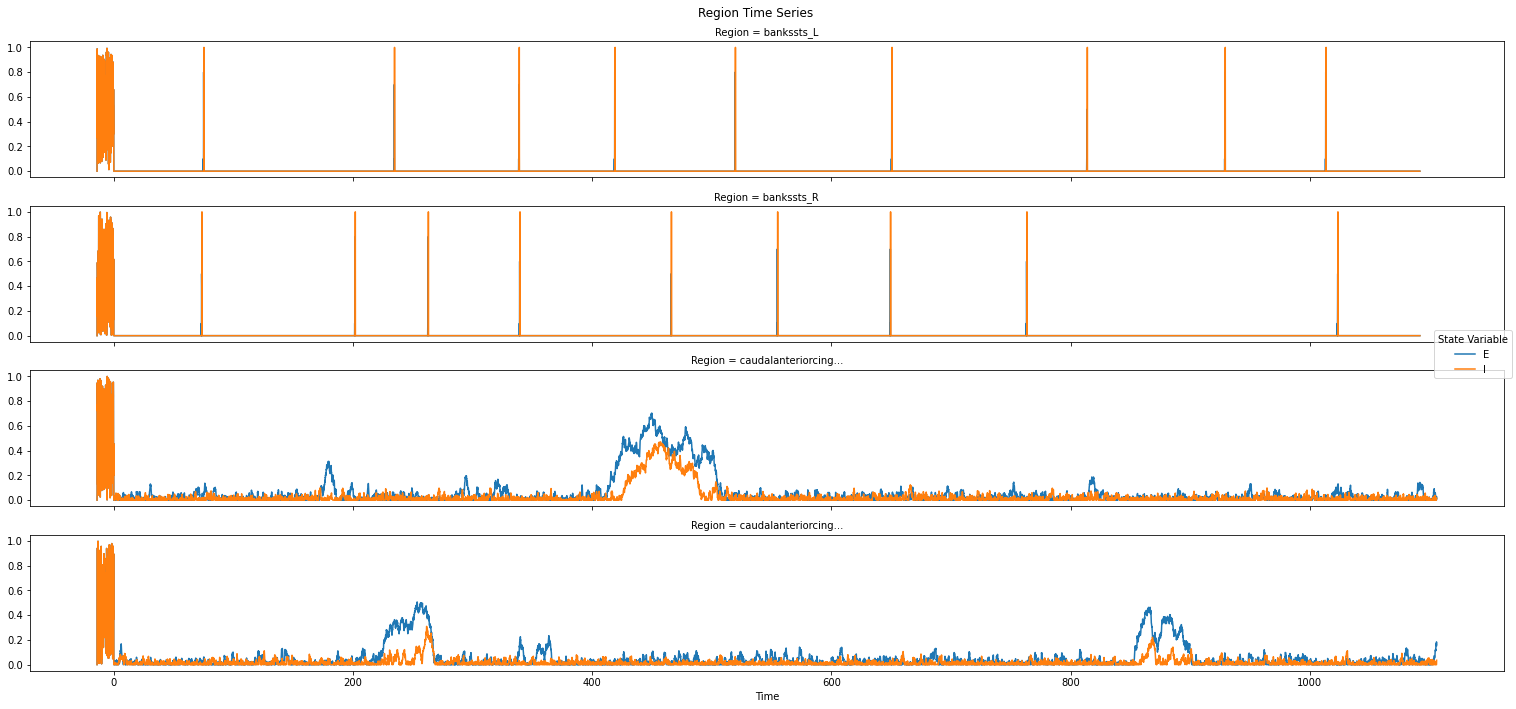

In [13]:
# Plot TVB time series
if source_ts is not None:
    source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

In [14]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts is not None and source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts.plot_raster(plotter_config=plotter.config, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
                          figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

In [15]:
# if source_ts is not None:
#     source_ts_adj = TimeSeriesXarray()
#     source_ts_adj.from_xarray_DataArray(
#                               source_ts._data.copy(),
#                                connectivity=source_ts.connectivity)
#     source_ts_adj.data[:, :, nest_model_builder.spiking_nodes_inds] *= 0.01
#     source_ts_adj.plot_timeseries(plotter_config=plotter.config, 
#                           hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
#                           figsize=FIGSIZE);
# TVB time series raster plot:
# if source_ts_adj is not None and source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_adj.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


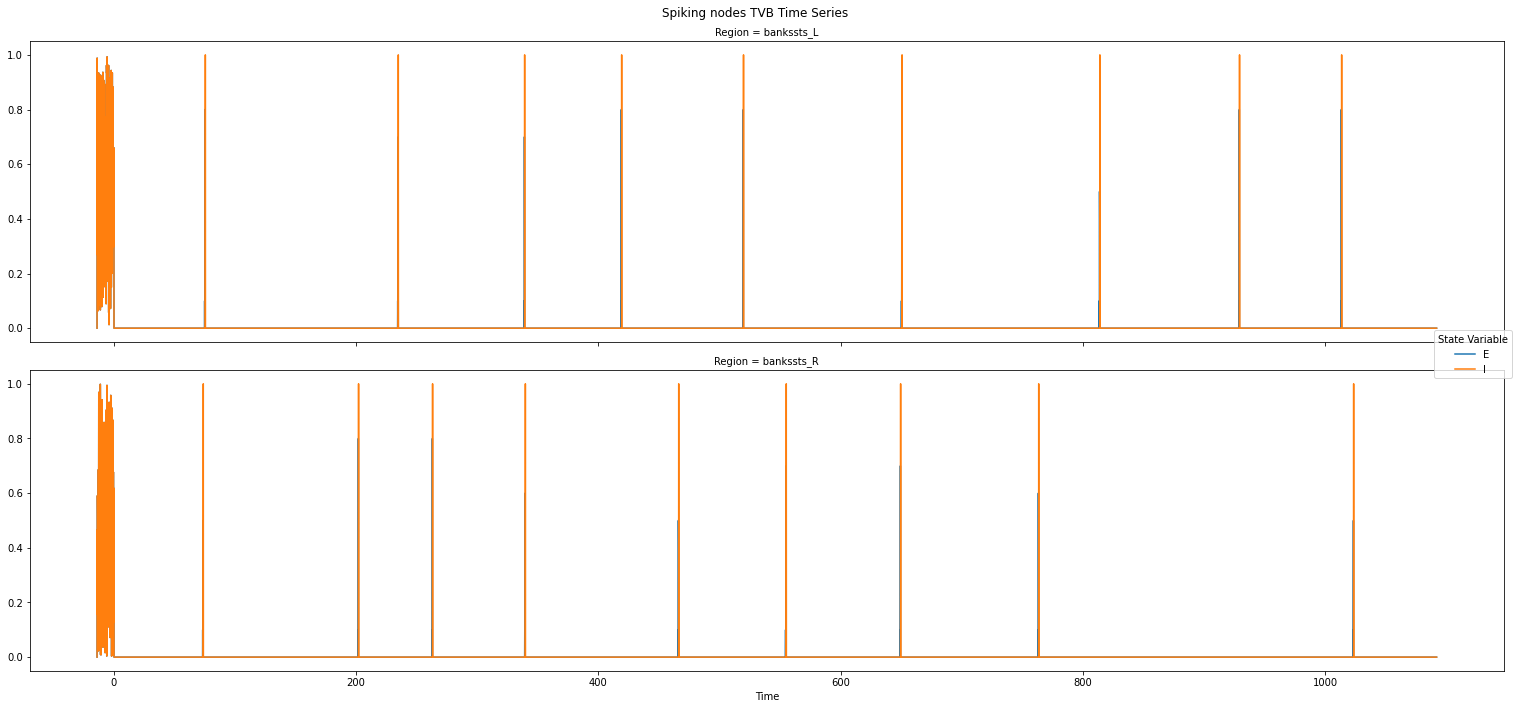

In [16]:
# Focus on the nodes modelled in NEST: 
n_spiking_nodes = len(nest_nodes_inds)
if source_ts is not None and n_spiking_nodes:
    source_ts_nest = source_ts[:, :, nest_nodes_inds]
    source_ts_nest.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_nest.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:1048: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


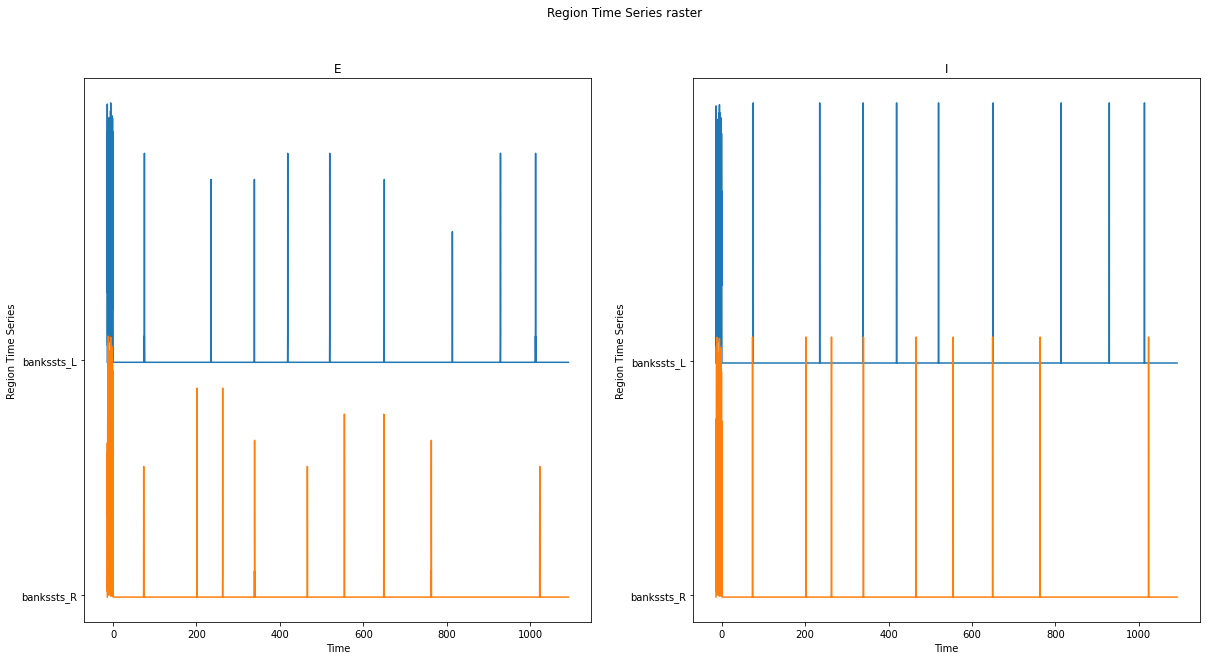

In [17]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts is not None and n_spiking_nodes: # and source_ts_nest.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_nest.plot_raster(plotter_config=plotter.config, 
                               per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS,
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [18]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

### Spiking Network plots

In [19]:
spikeNet_analyzer = None
if nest_network is not None:
    
    from tvb_multiscale.core.data_analysis.spiking_network_analyser import SpikingNetworkAnalyser
    # Create a SpikingNetworkAnalyzer:
    spikeNet_analyzer = \
        SpikingNetworkAnalyser(spikeNet=nest_network,
                               start_time=0.0, end_time=simulation_length, 
                               transient=transient, time_series_output_type="TVB", 
                               return_data=True, force_homogeneous_results=True, 
                               period=simulator.monitors[0].period, connectivity=simulator.connectivity
                              )

### Plot spikes' raster and mean spike rates and correlations

In [20]:
spikes_res = None
if spikeNet_analyzer is not None:
    
    # Spikes rates and correlations per Population and Region
    spikes_res = \
        spikeNet_analyzer.\
            compute_spikeNet_spikes_rates_and_correlations(
                populations_devices=None, regions=None,
                rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
                corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
                data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
                return_devices=False
            );

/home/docker/env/neurosci/lib/python3.9/site-packages/elephant/conversion.py:1168: UserWarning:Binning discarded 1 last spike(s) of the input spiketrain


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 2, Region: 2)>
array([[8.03697005, 8.03697005],
       [8.03697005, 8.03697005]])
Coordinates:
  * Region      (Region) object 'bankssts_L' 'bankssts_R'
  * Population  (Population) object 'E' 'I'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 2, Population_j: 2, Region_i: 2, Region_j: 2)>
array([[[[ 1.00000000e+00, -1.50371868e-03],
         [-1.50371868e-03,  1.00000000e+00]],

        [[-1.08133869e-03, -1.08133869e-03],
         [-1.09875232e-03, -1.09875232e-03]]],


       [[[-1.08133869e-03, -1.09875232e-03],
         [-1.08133869e-03, -1.09875232e-03]],

        [[ 1.00000000e+00, -7.90123457e-04],
         [-7.90123457e-04,  1.00000000e+00]]]])
Coordinates:
  * Population_i  (Population_i) object 'E' 'I'
  * Region_i      (Region_i) object 'bankssts_L' 'bankssts_R'
  * Population_j  (Population_j) object 'E' 'I'
  * Region_j      (Region_j) object 'bankssts_L' 'bankssts_R'


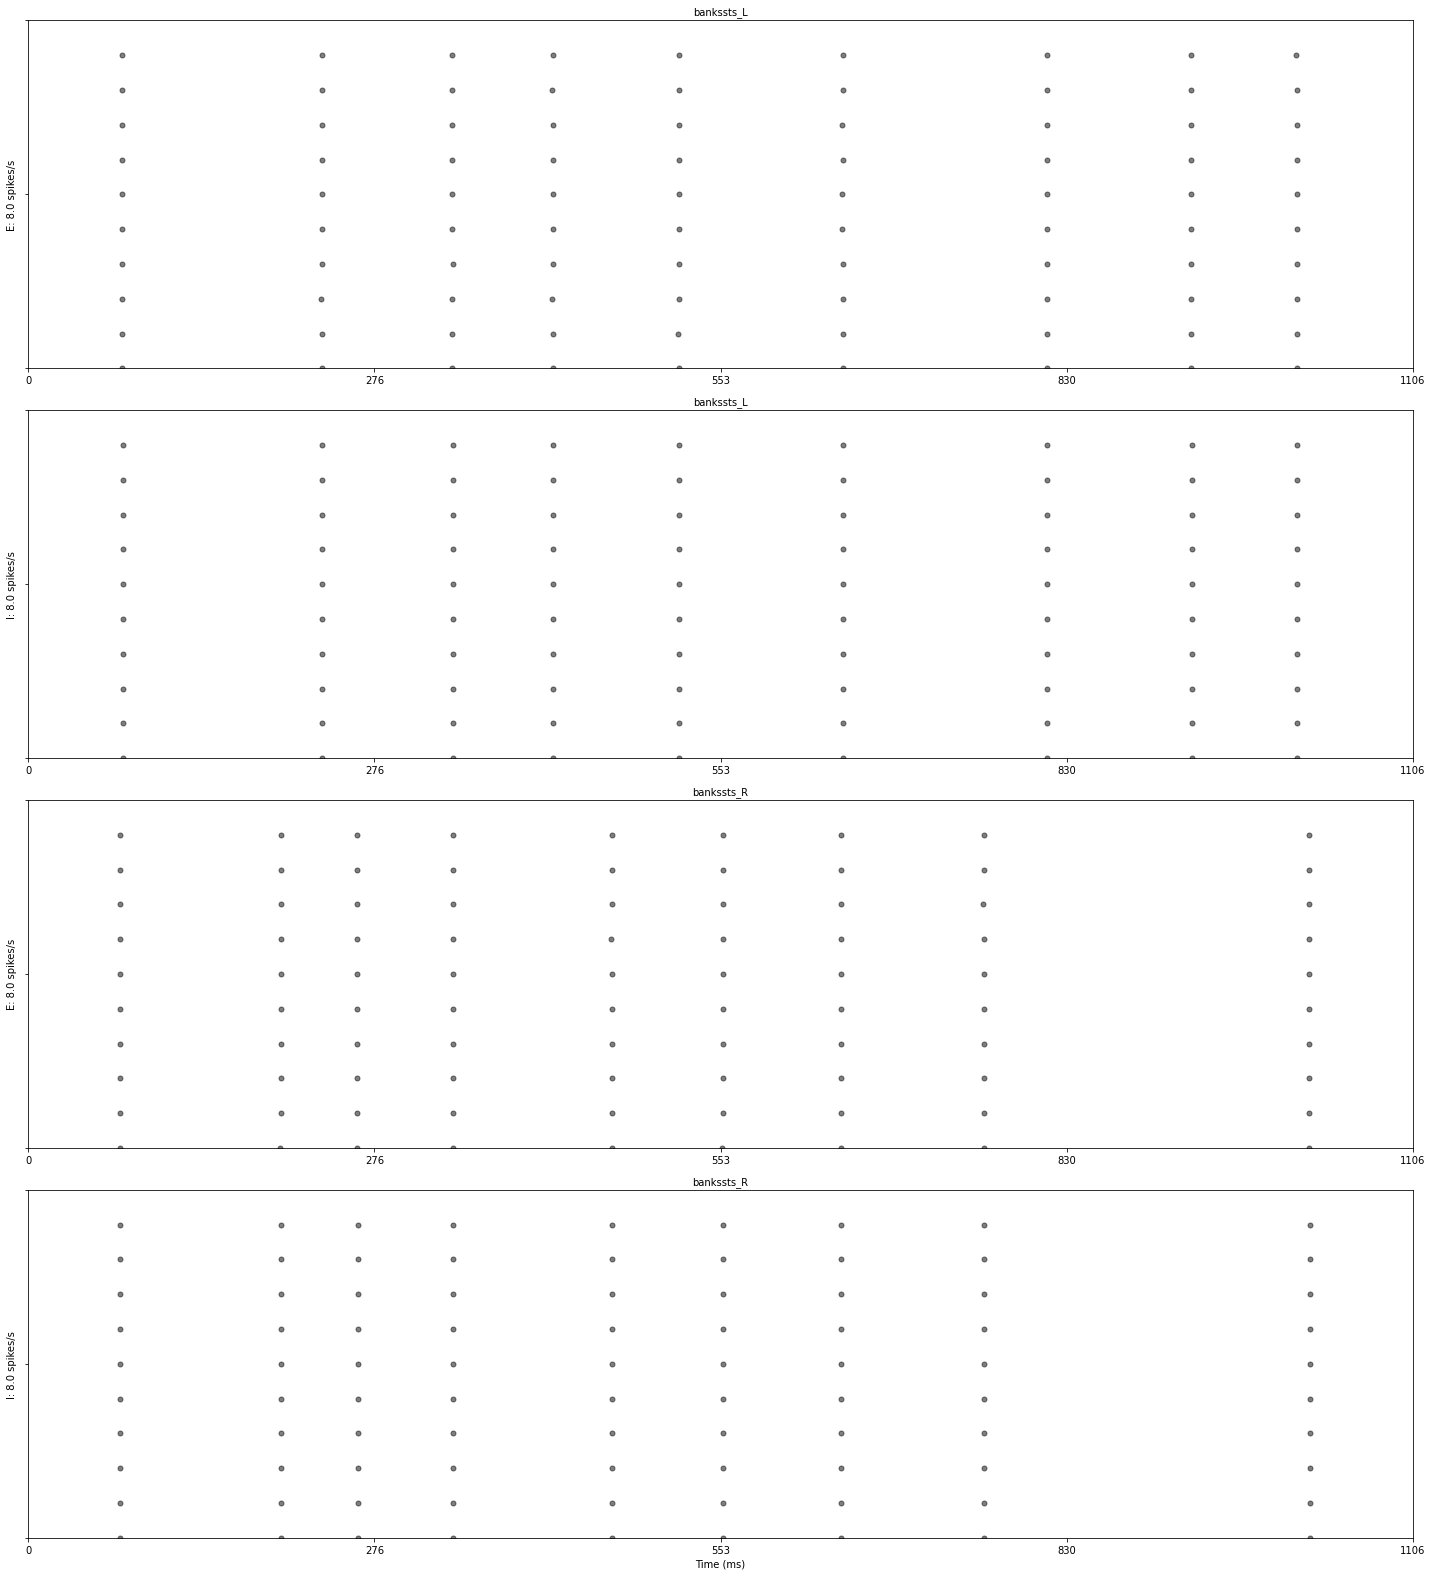

<Figure size 432x288 with 0 Axes>

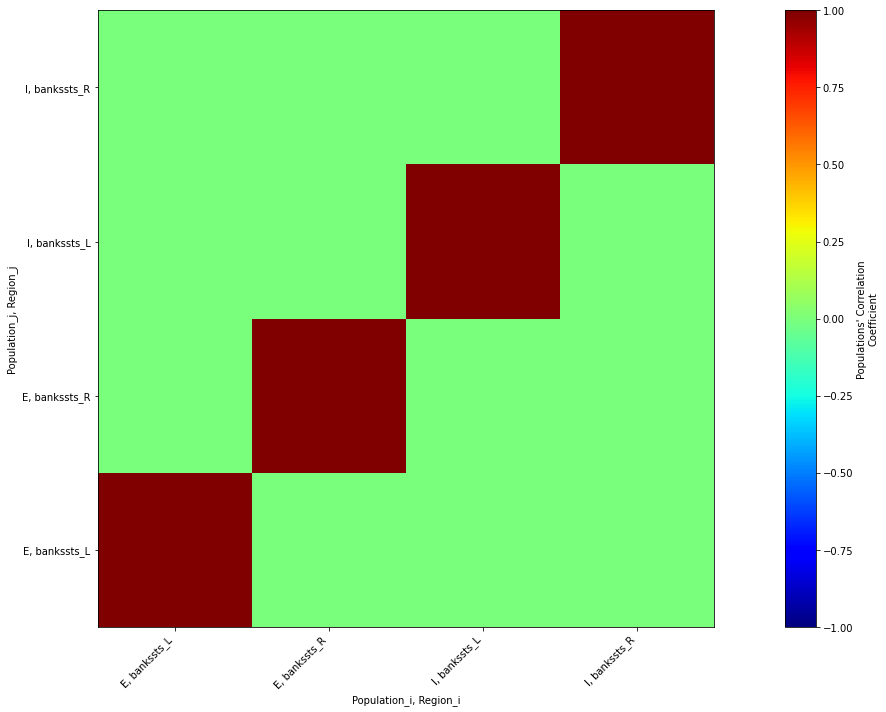

In [21]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], mean_results=spikes_res["mean_rate"], # time_series=spikes_res["mean_rate_time_series"], 
                                  figsize=(20, 22),  
                                  stimulus=None,
                                  stimulus_linewidth=5.0,
                                  spikes_markersize=5.0, spikes_alpha=0.5,
                                  n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                                  time_axis_min=0.0, time_axis_max=simulation_length)
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [22]:
if spikes_res:
    print("Mean spike rates:")
    for pop in spikes_res["mean_rate"].coords["Population"]:
        for reg in spikes_res["mean_rate"].coords["Region"]:
            if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_res["mean_rate"].loc[pop, reg].values.item()))

    # savemat(os.path.join(config.out.FOLDER_RES, "spikes_mean_rates.mat"), spikes_res["mean_rate"].to_dict())


Mean spike rates:
E - bankssts_L: 8.03697
E - bankssts_R: 8.03697
I - bankssts_L: 8.03697
I - bankssts_R: 8.03697


In [23]:
spikes_sync = None
# spikeNet_analyzer.resample = True
# spikes_sync = \
#     spikeNet_analyzer.compute_spikeNet_synchronization(populations_devices=None, regions=None,
#                                                        comp_methods=[spikeNet_analyzer.compute_spikes_sync, 
#                                                                      spikeNet_analyzer.compute_spikes_sync_time_series, 
#                                                                      spikeNet_analyzer.compute_spikes_distance, 
#                                                                      spikeNet_analyzer.compute_spikes_distance_time_series,
#                                                                      spikeNet_analyzer.compute_spikes_isi_distance, 
#                                                                      spikeNet_analyzer.compute_spikes_isi_distance_time_series],
#                                                        computations_kwargs=[{}], data_kwargs={},
#                                                        return_spikes_trains=False, return_devices=False)
# # print(spikes_sync)


In [24]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_sync_time_series"], 
                              mean_results=spikes_sync["spikes_sync"], 
                              stistimulus=[nest_model_builder.STIM_MF_START, 
                                           nest_model_builder.STIM_IO_START, 
                                           nest_model_builder.STIM_MF_END, 
                                           nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                              )

In [25]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_distance_time_series"], 
                              mean_results=spikes_sync["spikes_distance"], 
                              stimulus=[nest_model_builder.STIM_MF_START, 
                                        nest_model_builder.STIM_IO_START, 
                                        nest_model_builder.STIM_MF_END, 
                                        nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                                     )

In [26]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_isi_distance_time_series"], 
                              mean_results=spikes_sync["spikes_isi_distance"], 
                              stimulus=[nest_model_builder.STIM_MF_START, 
                                        nest_model_builder.STIM_IO_START, 
                                        nest_model_builder.STIM_MF_END, 
                                        nest_model_builder.STIM_IO_END] if STIMULUS else None,
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                                     )

In [27]:
if spikes_sync:
    print("Spike synchronization:")
    for pop in spikes_sync["spikes_sync"].coords["Population"]:
        for reg in spikes_sync["spikes_sync"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_sync"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_sync"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync.mat"), spikes_sync["spikes_sync"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync_time_series.mat"), spikes_sync["spikes_sync_time_series"].to_dict())

In [28]:
if spikes_sync:
    print("Spike distance:")
    for pop in spikes_sync["spikes_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance.mat"), spikes_sync["spikes_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance_time_series.mat"), spikes_sync["spikes_distance_time_series"].to_dict())

In [29]:
if spikes_sync:
    print("Spike ISI distance:")
    for pop in spikes_sync["spikes_isi_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_isi_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_isi_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_isi_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance.mat"), spikes_sync["spikes_isi_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance_time_series.mat"), spikes_sync["spikes_isi_distance_time_series"].to_dict())

In [30]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

### Get  SpikingNetwork mean field variable time series and plot them

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning:
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.


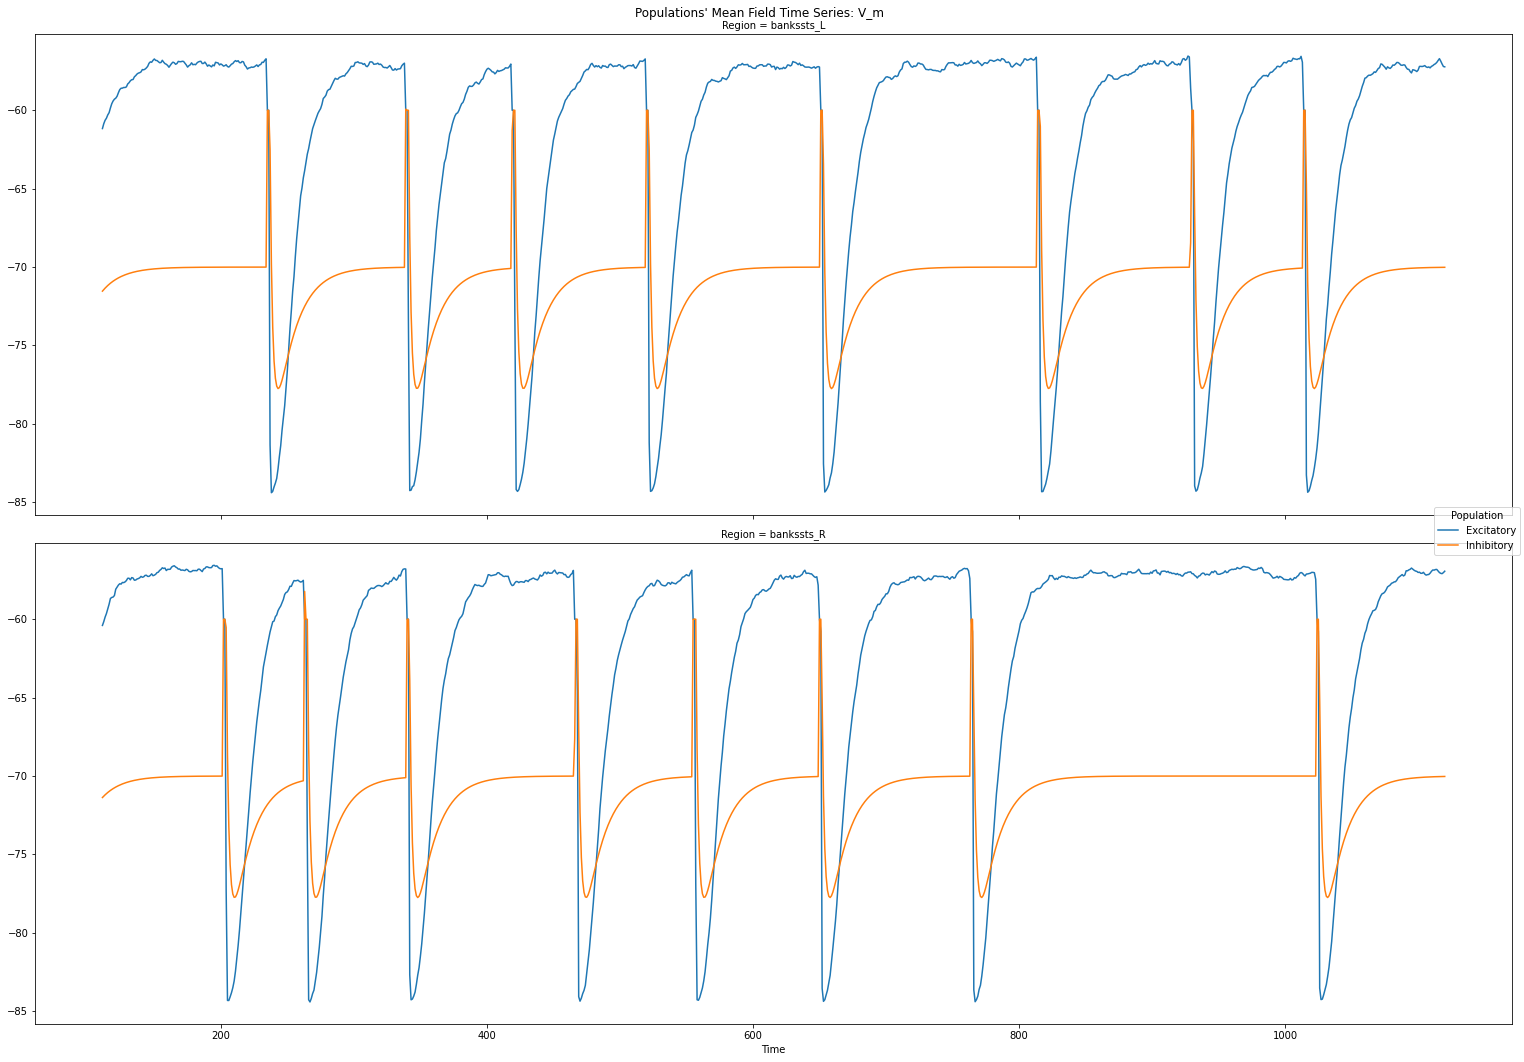

In [31]:
# Continuous time variables' data of spiking neurons
spikeNet_ts = None
mean_field_ts = None
if spikeNet_analyzer:
    if plot_per_neuron:
        spikeNet_analyzer.return_data = True
    else:
        spikeNet_analyzer.return_data = False
    spikeNet_ts = \
        spikeNet_analyzer. \
             compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                     computations_kwargs={}, data_kwargs={}, return_devices=False)
    if spikeNet_ts:
        if plot_per_neuron:
            mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
            spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
        else:
            mean_field_ts = spikeNet_ts
            spikeNet_ts = None
        if mean_field_ts and mean_field_ts.size > 0:
            mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                          per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
            if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
                mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                          per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                          linestyle="--", alpha=0.5, linewidth=0.5)


In [32]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [33]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [34]:
# Regions in rows
if spikeNet_ts is not None and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>